# T3 - Métodos de aprendizaje semi-supervisado



En esta práctica vamos a ver dos ejemplos: el primero, cómo funciona Naive Bayes con datos sin etiquetar, y el segundo, cómo podemos mejorar la versión básica del Naive Bayes aprendiendo un mejor modelo iterativamente mediante el algoritmo de EM.

## Naive Bayes SIN datos sin etiquetar

Realizamos los imports necesarios:

In [1]:
# Import packages and libraries
import numpy as np
import random as rnd

from scipy.sparse import csr_matrix
from sklearn.datasets import fetch_20newsgroups # ES UNA BASE DE DATOS QUE YA VIENE EN SKLEARN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB               # toma más de una variable
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

Cargamos nuestros datos:

In [2]:
# Load train and test data set with class labels
train_Xy = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
test_Xy = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

In [7]:
# print(train_Xy)

Utilizamos la transformación tf-Idf para convertir las palabras a una matriz de números:

In [3]:
# Convert all text data into tf-idf vectors
vectorizer = TfidfVectorizer(stop_words='english', min_df=3, max_df=0.9)
train_vec = vectorizer.fit_transform(train_Xy.data)
test_vec = vectorizer.transform(test_Xy.data)

In [4]:
test_vec.shape

(7532, 26747)

In [8]:
print(train_vec.shape)
print(train_vec[0, 1])

(11314, 26747)
0.0


Dividimos los datos entre etiquetados y no etiquetados:

In [9]:
# Divide train data set into labeled and unlabeled data sets
n_train_data = train_vec.shape[0]
split_ratio = 0.2 # labeled vs unlabeled
X_l, X_u, y_l, y_u = train_test_split(train_vec, train_Xy.target, train_size=split_ratio, random_state=42)
print(f'Número de instancias CON etiquetas: {X_l.shape}')
print(f'Número de instancias SIN etiquetas: {X_u.shape}')

Número de instancias CON etiquetas: (2262, 26747)
Número de instancias SIN etiquetas: (9052, 26747)


Entrenamos nuestro BN con únicamente los datos etiquetados:

In [11]:
nb_clf = MultinomialNB(alpha= 1e-8)# Aqui tu código
nb_clf.fit(X_l, y_l)

MultinomialNB(alpha=1e-08)

Y evaluamos su comportamiento:

In [12]:
# Evaluamos comportamiento NB
pred_nb = nb_clf.predict(test_vec)
print(metrics.classification_report(test_Xy.target, pred_nb, target_names=test_Xy.target_names))
print(f'Accuracy score={metrics.accuracy_score(test_Xy.target, pred_nb)}')

                          precision    recall  f1-score   support

             alt.atheism       0.56      0.13      0.21       319
           comp.graphics       0.54      0.32      0.40       389
 comp.os.ms-windows.misc       0.48      0.37      0.42       394
comp.sys.ibm.pc.hardware       0.61      0.42      0.49       392
   comp.sys.mac.hardware       0.65      0.43      0.51       385
          comp.windows.x       0.43      0.76      0.55       395
            misc.forsale       0.56      0.65      0.60       390
               rec.autos       0.73      0.42      0.53       396
         rec.motorcycles       0.80      0.41      0.55       398
      rec.sport.baseball       0.52      0.69      0.59       397
        rec.sport.hockey       0.78      0.85      0.81       399
               sci.crypt       0.59      0.67      0.63       396
         sci.electronics       0.59      0.20      0.30       393
                 sci.med       0.67      0.61      0.64       396
         

Text(0.5, 1.0, 'Matriz de Confusion')

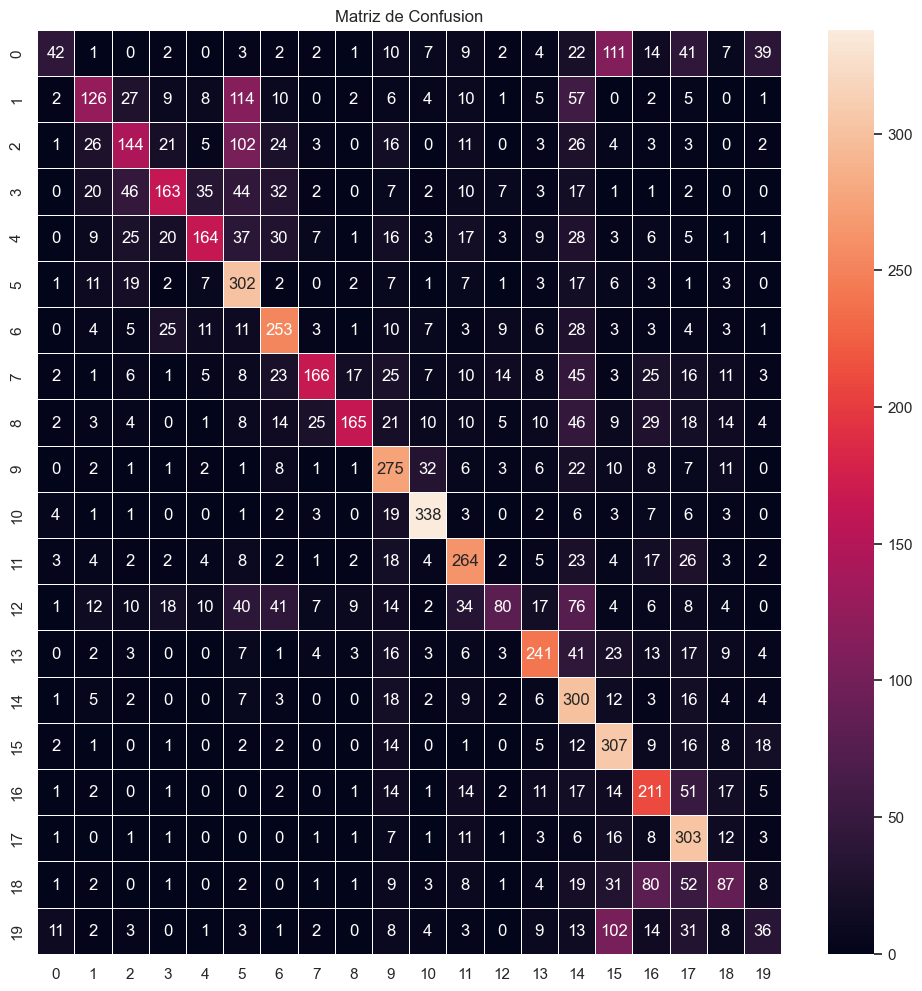

In [13]:
# Matriz de confusión
plt.figure(figsize=(12,12))
sns.set()
sns.heatmap(metrics.confusion_matrix(test_Xy.target, pred_nb), annot=True, fmt="d", linewidths=.5)
plt.title("Matriz de Confusion")

## EM con NaiveBayes

Nos descargamos la clase que implementa el algoritmo de EM:

In [20]:
!wget https://raw.githubusercontent.com/jerry-shijieli/Text_Classification_Using_EM_And_Semisupervied_Learning/master/code/Semi_EM_NB.py

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [21]:
import numpy as np

from copy import deepcopy
from scipy.sparse import csr_matrix, vstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from scipy.linalg import get_blas_funcs
from sklearn.semi_supervised import LabelPropagation, LabelSpreading

class Semi_EM_MultinomialNB():
    """
    Naive Bayes classifier for multinomial models for semi-supervised learning.
    
    Use both labeled and unlabeled data to train NB classifier, update parameters
    using unlabeled data, and all data to evaluate performance of classifier. Optimize
    classifier using Expectation-Maximization algorithm.
    """
    def __init__(self, alpha=1.0, fit_prior=True, class_prior=None, max_iter=30, tol=1e-6, print_log_lkh=True):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior = class_prior
        self.clf = MultinomialNB(alpha=self.alpha, fit_prior=self.fit_prior, class_prior=self.class_prior)
        self.log_lkh = -np.inf # log likelihood
        self.max_iter = max_iter # max number of EM iterations
        self.tol = tol # tolerance of log likelihood increment
        self.feature_log_prob_ = np.array([]) # Empirical log probability of features given a class, P(x_i|y).
        self.coef_ = np.array([]) # Mirrors feature_log_prob_ for interpreting MultinomialNB as a linear model.
        self.print_log_lkh = print_log_lkh # if True, print log likelihood during EM iterations

    def fit(self, X_l, y_l, X_u):
        """
        Initialize the parameter using labeled data only.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.fit(X_l, y_l) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T.toarray()]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T.toarray()) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        if self.print_log_lkh:
            print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            if self.print_log_lkh:
                print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose().toarray()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose().toarray()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            if self.print_log_lkh:
                print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

    def fit_with_clustering(self, X_l, y_l, X_u, y_u=None):
        """
        Initialize the parameter using both labeled and unlabeled data.
        The classes of unlabeled data are assigned using similarity with labeled data.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        The label propagation can only use dense matrix, so it is quite time consuming.
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs): 
        # assign class to unlabeled data using similarity with labeled data if y_u is not given
        if (y_u==None):
            label_prop_model = LabelSpreading(kernel='rbf', max_iter=5, n_jobs=-1)
            y_u = np.array([-1.0]*n_ul_docs)
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            label_prop_model.fit(X.toarray(), y)
            y_u = label_prop_model.predict(X_u.toarray())
        y = np.concatenate((y_l, y_u), axis=0)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.fit(X, y) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T.toarray()]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T.toarray()) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        if self.print_log_lkh:
            print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            if self.print_log_lkh:
                print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose().toarray()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose().toarray()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            if self.print_log_lkh:
                print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

    def partial_fit(self, X_l, y_l, X_u=np.array([])):
        """
        Initialize the parameter using labeled data only.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        This function can only be used after fit()
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.partial_fit(X_l, y_l) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T.toarray()]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T.toarray()) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.partial_fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose().toarray()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose().toarray()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

    def predict(self, X):
        return self.clf.predict(X)

    def score(self, X, y):
        return self.clf.score(X, y)

    def get_params(deep=True):
        return self.clf.get_params(deep)

    def __str__(self):
        return self.clf.__str__()

La importamos:

In [23]:
# from Semi_EM_NB import Semi_EM_MultinomialNB

Entrenamos nuestro NB con EM usando los datos etiquetados y los no etiquetados:

In [16]:

X_l.shape

(2262, 26747)

In [17]:
X_u.shape

(9052, 26747)

In [18]:
test_Xy.target.shape

(7532,)

In [24]:
em_nb_clf = Semi_EM_MultinomialNB(alpha= 1e-4, max_iter= 30, tol= 0.00001)# Aqui tu código
em_nb_clf.fit(X_l, y_l, X_u)

Initial expected log likelihood = -5419024.722

EM iteration #1
	Expected log likelihood = -4528617.023
EM iteration #2
	Expected log likelihood = -4527624.345
EM iteration #3
	Expected log likelihood = -4527472.759
EM iteration #4
	Expected log likelihood = -4527455.875
EM iteration #5
	Expected log likelihood = -4527449.533
EM iteration #6
	Expected log likelihood = -4527449.533


AttributeError: 'MultinomialNB' object has no attribute 'coef_'

Y lo evaluamos:

In [ ]:
# Evaluamos su comportamiento
pred_em_nb = em_nb_clf.predict(test_vec)
print(metrics.classification_report(test_Xy.target, pred_em_nb, target_names=test_Xy.target_names))
print(f'Accuracy score={metrics.accuracy_score(test_Xy.target, pred_em_nb)}')

In [ ]:
# plot confusion matrix for test dataset
plt.figure(figsize=(12,12))
sns.set()
sns.heatmap(metrics.confusion_matrix(test_Xy.target, pred_em_nb), annot=True, fmt="d", linewidths=.5)
plt.title("Matriz de Confusion")

Veamos las distribuciones aprendidas:

In [ ]:
print('NB: ', nb_clf.class_log_prior_)
print('EM NB: ', em_nb_clf.clf.class_log_prior_)

Y para ver de una forma más visual la mejora que ha habido, veamos la diferencia entre las matrices de confusión:

In [ ]:
# plot diferencias entre las matrices de confusion
plt.figure(figsize=(12,12))
sns.set()
sns.heatmap(metrics.confusion_matrix(test_Xy.target, pred_em_nb) - metrics.confusion_matrix(test_Xy.target, pred_nb), annot=True, fmt="d", linewidths=.5)
plt.title("Diferencias entre NB y EM NB")

FUENTE: https://github.com/jerry-shijieli/Text_Classification_Using_EM_And_Semisupervied_Learning/

- Explicaciones de NB bastante didácticas y útiles:
   - https://towardsdatascience.com/all-about-naive-bayes-8e13cef044cf
   - https://medium.com/@srishtisawla/introduction-to-naive-bayes-for-classification-baefefb43a2d
- Uso de NB para sentiment analysis con código y muy didáctico: https://levelup.gitconnected.com/movie-review-sentiment-analysis-with-naive-bayes-machine-learning-from-scratch-part-v-7bb869391bab